<i><b>Notebook created by:</b> Matilda Eriksson, 2020-04-26<br>
    <b>Source of Data:</b> Codecademy.com</i>

# Supervised Machine Learning: Viral Tweets

This project is a part of the Data Science course I took on Codecademy.com. I will use KNN to predict whether a tweet will go viral or not.
<br>
I will also deal with the following questions:
- What is the best number of K's?
- How to define a viral tweet
- The importance of accuracy vs. precision & recall 
- How to deal with imbalanced data 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Importing the data
all_tweets = pd.read_json("random_tweets.json", lines=True)

print(len(all_tweets))
print(all_tweets.columns)

11099
Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'retweeted_status',
       'is_quote_status', 'retweet_count', 'favorite_count', 'favorited',
       'retweeted', 'lang', 'possibly_sensitive', 'quoted_status_id',
       'quoted_status_id_str', 'extended_entities', 'quoted_status',
       'withheld_in_countries'],
      dtype='object')


In [3]:
# Any duplicates?
all_tweets['id'].duplicated().sum()

0

In [4]:
# Adding some features from dictionary values 
all_tweets['tweet_length'] = all_tweets.apply(lambda tweet: len(tweet['text']), axis=1)
all_tweets['followers_count'] = all_tweets.apply(lambda tweet: tweet['user']['followers_count'], axis=1)
all_tweets['friends_count'] = all_tweets.apply(lambda tweet: tweet['user']['friends_count'], axis=1)
all_tweets['language'] = all_tweets.apply(lambda tweet: tweet['metadata']['iso_language_code'], axis=1)

# <b>What is a viral tweet?</b>
I will have to label all tweets as viral or not viral. That also means I need to think about the defintion of what a viral tweet is. If this was a real businesscase, this would be a typical example of when it's extremely important that I as an analyst aligned with all relevant stakeholders.</b>

In [5]:
display(np.mean(all_tweets['retweet_count']))
display(np.median(all_tweets['retweet_count']))

2777.95639246779

13.0

<i>The difference between the average and the median number of retweets is very big and the data is right skewed. Most tweets are probably never retweeted.

<b>In this case, I will define a tweet as viral if the number of retweets is above the average.</b> If we would define a tweet as viral if the number of retweets is above the median, that means a tweet with 14 retweets would be defined as viral. That does not sound accurate.</i>

In [6]:
# I will label the tweets as viral if they have a retweet count above average 
average = np.round(np.mean(all_tweets['retweet_count']))
all_tweets['is_viral'] = np.where(all_tweets['retweet_count'] > average, 1, 0)
all_tweets['is_viral'].value_counts()

0    9625
1    1474
Name: is_viral, dtype: int64

<i>The classes are very imbalanced. This might caue for a biased and non accurate model</i>

In [7]:
# Separating features and labels
labels = all_tweets['is_viral']
data = all_tweets[['tweet_length', 'followers_count', 'friends_count']]

In [8]:
# Scaling the feature values
from sklearn.preprocessing import scale

scaled_data = scale(data, axis=0)

In [9]:
# Creating train/test split
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, labels, test_size=0.2, random_state=1)

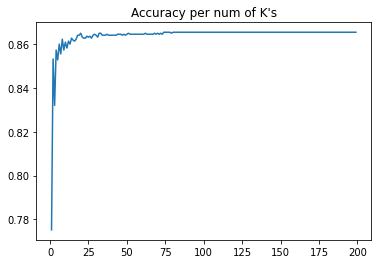

In [10]:
# Choosing the best number of K's
from sklearn.neighbors import KNeighborsClassifier

scores = []
for k in range(1,200):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(train_data, train_labels)
    scores.append(classifier.score(test_data, test_labels))
    
plt.plot(range(1,200), scores)
plt.title('''Accuracy per num of K's''')
plt.show()

In [11]:
# The model performs very similar at many different K's. 
# I will round the score to two decimals and then find the K that had the best score
scores = np.round(scores, 2)

In [12]:
max(scores)

0.87

In [13]:
np.argmax(scores, axis=0)

73

In [14]:
best_classifier = KNeighborsClassifier(n_neighbors=74)
best_classifier.fit(train_data, train_labels)
y_pred = best_classifier.predict(test_data)

In [15]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1921
           1       0.00      0.00      0.00       299

    accuracy                           0.87      2220
   macro avg       0.43      0.50      0.46      2220
weighted avg       0.75      0.87      0.80      2220



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
unique_elements, counts_elements = np.unique(y_pred, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[   0]
 [2220]]


# Evaluation
Our model performs best when we use 74 K's. It then has an accuracy score of 87 %, but the model did not correctly predict any single viral tweet, which was the whole purpose! This is not a good model. 

# Oversampling
I suspect that the imbalance in the training data might bee the case for the low precision score.

To deal with this I will do oversampling by using SMOTE.

In [32]:
# Transform the dataset to an equal ratio of each binary class (viral or not viral)
from imblearn.over_sampling import SMOTE 
oversample = SMOTE(random_state=42)
train_data_sampled, train_labels_sampled = oversample.fit_resample(train_data, train_labels)

In [33]:
print(np.unique(train_labels_sampled,return_counts=True))

(array([0, 1]), array([7704, 7704]))


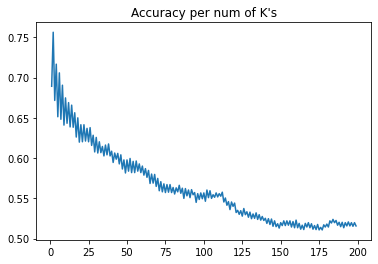

In [34]:
scores = []
for k in range(1,200):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(train_data_sampled, train_labels_sampled)
    scores.append(classifier.score(test_data, test_labels))
    
plt.plot(range(1,200), scores)
plt.title('''Accuracy per num of K's''')
plt.show()

In [35]:
max(np.round(scores,2))

0.76

In [36]:
np.argmax(scores, axis=0)

1

- With the resampled data, the model performs best when K=2. The accuracy is then 76%. Lower than before, but let's look at the correctly identified "viral tweets" (recall)

In [37]:
classifier_sampled = KNeighborsClassifier(n_neighbors=2)
classifier_sampled.fit(train_data_sampled, train_labels_sampled)
y_pred = classifier_sampled.predict(test_data)
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1921
           1       0.18      0.24      0.21       299

    accuracy                           0.76      2220
   macro avg       0.53      0.54      0.53      2220
weighted avg       0.78      0.76      0.77      2220



In [38]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, y_pred)

array([[1608,  313],
       [ 228,   71]])

- The recall is now up to 24%. Not perfect, but better.

At what K do we get the best recall score?

In [40]:
from sklearn.metrics import recall_score
recall_scores = []
for k in range(1,200):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(train_data_sampled, train_labels_sampled)
    y_pred = classifier.predict(test_data)
    recall_scores.append(np.round(recall_score(test_labels, y_pred),2))

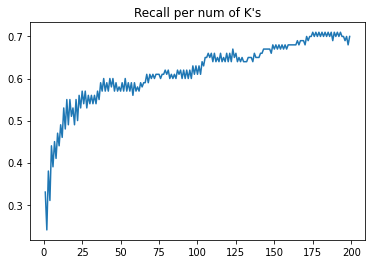

In [41]:
plt.plot(range(1,200), recall_scores)
plt.title('''Recall per num of K's''')
plt.show()

In [42]:
# Best Recall Score
max(recall_scores)

0.71

In [43]:
# How many K's?
np.argmax(recall_scores, axis=0)

174

In [44]:
recall_classifier = KNeighborsClassifier(n_neighbors=189)
recall_classifier.fit(train_data_sampled, train_labels_sampled)
recall_classifier.score(test_data, test_labels)

0.5148648648648648

In [45]:
y_pred_recall = recall_classifier.predict(test_data)
print(classification_report(test_labels, y_pred_recall))

              precision    recall  f1-score   support

           0       0.91      0.48      0.63      1921
           1       0.18      0.71      0.28       299

    accuracy                           0.51      2220
   macro avg       0.55      0.60      0.46      2220
weighted avg       0.82      0.51      0.59      2220



In [46]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, y_pred_recall)

array([[931, 990],
       [ 87, 212]])

# Summary

Different kind of scores are more or less important depending on what we want to achieve with our model. The main purpose in this project was to predict what tweets will go viral, so the recall score is very important in this case. When using K=189, the model correctly identified 71% of the viral tweets. <b>How ever</b> the accuracy of that model was as low as 52%, which is basically just a tiny bit better than labeling completely random.
<br>
<br>
Because of that, I would recommend using a k=2, where the recall is lower, but the accuracy is acceptable.
